In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import *
from IPython.display import HTML, display
from ipywidgets import Output

# Part 1

In [2]:
# dataset: [X, y]
dataset = sklearn.datasets.load_iris(return_X_y=True)

# Extract feature labels for Part 4
features = list(sklearn.datasets.load_iris(return_X_y=True, as_frame=True)[0].columns)

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
dataset = (scaler.fit_transform(*dataset), dataset[1])

# Split data
TRAIN_SPLIT = 0.8
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    *dataset,
    train_size=TRAIN_SPLIT, test_size=1 - TRAIN_SPLIT,
    stratify=dataset[1],
    random_state=15
)

# Print input shape and target class distribution
print(f"X shape: {"x".join(map(str, dataset[0].shape))}")
print(f"y distribution:\n{"\n".join([f"\t{k}: {v / len(dataset[1]) * 100:.2f}%" for k, v in Counter(dataset[1]).items()])}")

# Functions to handle each problem
classes = np.array([c for c in set(dataset[1])])
def convert_y(y, c):
    return (y[:] == c).astype(np.int8)
def logits_to_class(logits):
    axis = 1 - len(logits.shape)
    mask = logits >= 0.5
    return np.where(np.any(mask, axis=axis), np.argmax(mask, axis=axis), -1)

X shape: 150x4
y distribution:
	0: 33.33%
	1: 33.33%
	2: 33.33%


# Part 2

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lr_model(X, w):
    return sigmoid(X @ w.T)

def lr_loss(X, y, w):
    y_hat = lr_model(X, w)
    return np.sum((y[:] * np.log(y_hat[:])) + ((1 - y[:]) * np.log(1 - y_hat[:])))

def lr_loss_grad(X, y, w):
    y_hat = lr_model(X, w)
    return (y - y_hat) @ X

def logistic_regression(X, y, learning_rate=0.0001, num_iterations=10_000):
    w = np.random.normal(size=X.shape[1])
    loss = np.ndarray(shape=num_iterations)
    for i in range(num_iterations):
        loss[i] = lr_loss(X, y, w)
        w += learning_rate * lr_loss_grad(X, y, w)
    return {
        "weights": w,
        "loss": loss,
    }

def multi_class_logistic_regression(X, y, **kwargs):
    results = [
        logistic_regression(X, convert_y(y, c), **kwargs)
        for c in classes
    ]
    return {
        "weights": np.stack([r["weights"] for r in results]),
        "loss": np.stack([r["loss"] for r in results]).T,
    }

def print_accuracy(X, y, weights):
    logits = lr_model(X, weights)
    print("Predicted:")
    print(predicted := logits_to_class(logits))
    print("Actual:")
    print(y)
    print("Accuracy:")
    print(f"\tOverall: {sum(p == a for p, a in zip(predicted, y)) / len(predicted) * 100:.2f}%")
    print("\tPer-class:")
    for i, c in enumerate(classes):
        class_y = convert_y(y, c)
        print(f"\t\tClass {c}: {sum(p == a for p, a in zip(logits.T[c] >= 0.5, class_y)) / len(class_y) * 100:.2f}%")

Weights:
	Class 0: [-1.14916009  2.66810225 -2.25282325 -3.0116272 ]
	Class 1: [ 0.04294722 -1.08643332  1.0388668  -1.12896514]
	Class 2: [-0.30307313  0.72223098  0.23319575  2.53294819]
Final Loss:
	Total: -116.01786996196793
	Per-class: [ -3.55885135 -68.19362015 -44.26539847]
Loss curves


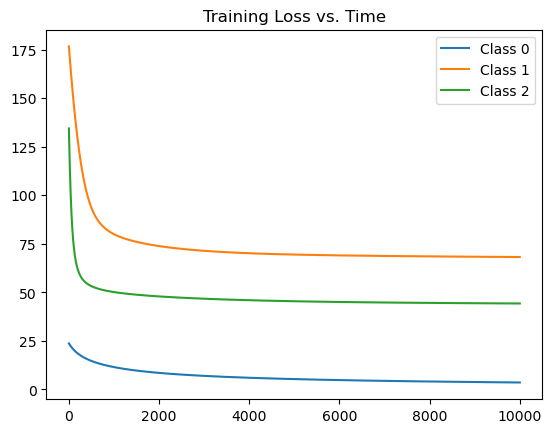

Predicted:
[1 0 2 1 1 1 1 0 2 1 0 1 0 1 1 0 0 1 1 2 0 1 1 0 1 1 2 2 1 1 2 2 1 1 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 1 2 1 0 1 2 2 0 0 1 0 0 0 1 2 0 0 2 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 1 0 1 2 1 1 0 1 0 1 0 2 1 1 2
 2 2 0 0 1 1 2 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1 2
 1 0 0 0 1 0 1 2 1 2 1 1 1 0 2 1 2 1 2 2 1 0 1 0 2 2 1 1 0 2 0 2 0 1 1 1 2
 2 2 0 0 1 2 2 0 1]
Accuracy:
	Overall: 77.50%
	Per-class:
		Class 0: 100.00%
		Class 1: 70.83%
		Class 2: 77.50%


In [4]:
model = multi_class_logistic_regression(train_X, train_y)

print("Weights:")
print("\n".join(f"\tClass {c}: {model["weights"][i]}" for i, c in enumerate(classes)))
print("Final Loss:")
print(f"\tTotal: {sum(model["loss"][-1])}")
print(f"\tPer-class: {model["loss"][-1]}")
print("Loss curves")
plt.title("Training Loss vs. Time")
plt.plot(model["loss"] * -1)
plt.legend([f"Class {c}" for c in classes])
plt.show()

print_accuracy(train_X, train_y, model["weights"])

del model

# Part 3

In [5]:
def get_top_k_features(weights, k):
    return [
        features[i]
        for i, _ in sorted(
            enumerate(weights_no_reg[i]),
            key=lambda t: t[1],
            reverse=True
        )[:k]
    ]

weights_no_reg = np.stack([
    sklearn.linear_model.LogisticRegression(penalty=None)
        .fit(train_X, convert_y(train_y, c))
        .coef_[0]
    for c in classes
])

print("Weights:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {weights_no_reg[i]}")
print("Top 3 features:")
for i, c in enumerate(classes):
    print(f"\tClass {c}: {", ".join(get_top_k_features(weights_no_reg, 3))}")

print()
print_accuracy(train_X, train_y, weights_no_reg)

print()
confusion = sklearn.metrics.confusion_matrix(test_y, logits_to_class(lr_model(test_X, weights_no_reg)))
print("Confusion Matrix:")
print(confusion)
del confusion

Weights:
	Class 0: [-1.9533204   2.91955752 -6.43249944 -5.32207779]
	Class 1: [-0.64884866 -0.9812195   3.59730859 -2.90076526]
	Class 2: [ -5.62437423 -26.06602412  90.21342948 157.21832397]
Top 3 features:
	Class 0: sepal width (cm), sepal length (cm), petal width (cm)
	Class 1: petal length (cm), sepal length (cm), sepal width (cm)
	Class 2: petal width (cm), petal length (cm), sepal length (cm)

Predicted:
[1 0 2 1 1 1 1 0 2 1 0 1 0 1 1 0 0 1 1 2 0 1 1 0 1 1 2 2 1 1 2 2 1 1 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 2 1 2 1 0 1 2 2 0 0 1 0 0 0 1 2 0 0 2 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 2 0 1 2 1 1 0 1 0 1 0 2 1 1 2
 2 2 0 0 1 1 2 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1 2
 1 0 0 0 1 0 1 2 1 2 1 1 1 0 2 1 2 1 2 2 1 0 1 0 2 2 1 1 0 2 0 2 0 1 1 1 2
 2 2 0 0 1 2 2 0 1]
Accuracy:
	Overall: 75.83%
	Per-class:
		Class 0: 100.00%
		Class 1: 69.17%
		Class 2: 

# Part 4

In [6]:
weights_L1_reg = np.stack([
    sklearn.linear_model.LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
        .fit(train_X, convert_y(train_y, c))
        .coef_[0]
    for c in classes
])
print("Weights:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {weights_L1_reg[i]}")
print("Zeroed features:")
for i, c  in enumerate(classes):
    print(f"\tClass {c}: {", ".join([f for f, w in zip(features, weights_L1_reg[i]) if w == 0])}")
print("Top 3 features:")
for i, c in enumerate(classes):
    print(f"\tClass {c}: {", ".join(get_top_k_features(weights_L1_reg, 3))}")

print()
print_accuracy(train_X, train_y, weights_L1_reg)

for i, c in enumerate(classes):
    print()
    print(f"Weight comparison table for class {c}:")
    df = pd.DataFrame({
        "Feature": features,
        "Weight (no reg)": weights_no_reg[i],
        "|Weight|": np.abs(weights_no_reg[i]),
        "Weight (L1)": weights_L1_reg[i],
        "Zeroed?": weights_L1_reg[i] == 0
    })
    display(HTML(df.to_html(index=False)))
del df

Weights:
	Class 0: [ 0.          0.15306927 -2.0261636   0.        ]
	Class 1: [ 0.         -0.55947731  0.          0.        ]
	Class 2: [0.         0.         0.         1.48314593]
Zeroed features:
	Class 0: sepal length (cm), petal width (cm)
	Class 1: sepal length (cm), petal length (cm), petal width (cm)
	Class 2: sepal length (cm), sepal width (cm), petal length (cm)
Top 3 features:
	Class 0: sepal width (cm), sepal length (cm), petal width (cm)
	Class 1: petal length (cm), sepal length (cm), sepal width (cm)
	Class 2: petal width (cm), petal length (cm), sepal length (cm)

Predicted:
[0 0 2 1 1 1 1 0 1 1 0 1 0 1 2 0 0 1 1 2 0 1 1 0 1 2 2 2 1 1 1 1 1 1 2 0 0
 0 0 1 1 2 1 1 0 0 0 0 1 1 0 0 0 2 2 2 1 0 2 1 2 0 0 1 0 0 0 1 2 0 0 1 1 1
 2 0 0 0 2 0 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 0 0 1 2 1 1 0 1 0 1 0 1 1 1 2
 1 2 0 0 1 1 1 0 1]
Actual:
[1 0 2 1 1 1 2 0 2 1 0 1 0 2 1 0 0 1 2 2 0 2 1 0 2 1 2 2 2 2 2 2 2 2 2 0 0
 0 0 1 1 2 1 2 0 0 0 0 1 1 0 0 0 1 2 1 1 0 2 2 2 0 0 1 0 0 0 1 1 0 0 2 1

Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-1.953320,1.953320,0.000000,True
sepal width (cm),2.919558,2.919558,0.153069,False
petal length (cm),-6.432499,6.432499,-2.026164,False
petal width (cm),-5.322078,5.322078,0.000000,True



Weight comparison table for class 1:


Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-0.648849,0.648849,0.000000,True
sepal width (cm),-0.981219,0.981219,-0.559477,False
petal length (cm),3.597309,3.597309,0.000000,True
petal width (cm),-2.900765,2.900765,0.000000,True



Weight comparison table for class 2:


Feature,Weight (no reg),|Weight|,Weight (L1),Zeroed?
sepal length (cm),-5.624374,5.624374,0.000000,True
sepal width (cm),-26.066024,26.066024,0.000000,True
petal length (cm),90.213429,90.213429,0.000000,True
petal width (cm),157.218324,157.218324,1.483146,False
